
# Training 1D TFNO on Burger's Flow

### Import Packages and Load Data

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from neuralop.models import TFNO, TFNO1d
from neuralop import Trainer
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
device = 'cpu'

In [3]:
# load data
dfinput = pd.read_csv("visinputstept1sigmoid.csv", header = None)
dfoutput = pd.read_csv("visoutputstept1sigmoid.csv", header = None)
dfbwinput = pd.read_csv("backwardsvisinputstept1sigmoid.csv", header = None)
dfbwoutput = pd.read_csv("backwardsvisoutputstept1sigmoid.csv", header = None)


In [4]:
dfinput = pd.DataFrame.astype(dfinput, 'float32')
dfoutput = pd.DataFrame.astype(dfoutput, 'float32')
dfbwinput = pd.DataFrame.astype(dfbwinput, 'float32')
dfbwoutput = pd.DataFrame.astype(dfbwoutput, 'float32')

In [5]:
datainput = np.concatenate((pd.DataFrame.to_numpy(dfinput), pd.DataFrame.to_numpy(dfbwinput)))
dataoutput = np.concatenate((pd.DataFrame.to_numpy(dfoutput), pd.DataFrame.to_numpy(dfbwoutput)) )

In [6]:
len(datainput)

2800

In [7]:
#shuffle data
order = np.arange(len(datainput))
np.random.shuffle(order)
datainput = datainput[order]
dataoutput= dataoutput[order]

In [8]:
# split into input/output, test + train

samples = len(datainput)

n_train = 2400
n_test = samples - n_train

x_train = datainput[0:n_train,:]
x_test = datainput[n_train:samples,:]

y_train = dataoutput[0:n_train,:]
y_test = dataoutput[n_train:samples,:]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [9]:
#subsample data

x_train = x_train[::125]
y_train = y_train[::125]

In [10]:
trainn = []
testt = []

# convert to dictionary

for i in range(len(x_train)):
    trainn.append({"x": x_train[i].unsqueeze(0), "y": y_train[i].unsqueeze(0)})
    

for i in range(len(x_test)):
    testt.append({"x": x_test[i].unsqueeze(0), "y": y_test[i].unsqueeze(0)})



In [11]:
# create grids

s = x_train.size(-1)

grid = [-np.pi,np.pi]
grid1 = torch.linspace(grid[0], grid[1], s + 1)[0:-1].view(1,-1)
grid2 = torch.zeros(1, s)


In [12]:
#append grid 
for i in range(len(trainn)):
    trainn[i]["x"] = torch.stack([trainn[i]["x"], grid1, grid2])
#     trainn[i]["y"] = trainn[i]["y"].unsqueeze(1)


    trainn[i]["x"] = trainn[i]["x"].squeeze()
#     trainn[i]["y"] = trainn[i]["y"].squeeze()

    
for i in range(len(testt)):
    testt[i]["x"] = torch.Tensor(torch.stack([testt[i]["x"], grid1,grid2]))
#     testt[i]["x"] = torch.permute(testt[i]["x"],  (0,2,1))

    
#     testt[i]["y"] = testt[i]["y"].unsqueeze(1)
#     testt[i]["y"] = torch.permute(testt[i]["y"], (0,2,1))


    testt[i]["x"] = testt[i]["x"].squeeze()
#     testt[i]["y"] = testt[i]["y"].squeeze()
    



In [66]:
batch_train = 8
batch_test = 8

# load data

    
train_loader = torch.utils.data.DataLoader(trainn, batch_size=batch_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testt, batch_size=batch_test, shuffle=False)

## Create FNO Model

In [68]:
model = TFNO1d(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', 
               rank=0.42, n_modes_height = 16)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 33089 parameters.


In [69]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [70]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
l1loss = LpLoss(d=2, p=1)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss, "l1": l1loss}

In [71]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO1d(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 8), rank=(20, 20, 5))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
  )
  (projection): Projection(
    (fc1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (fc2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0008
    lr: 0.0008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x000001D08582ECD0>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at 0x000001D0858

In [72]:
#load scheduler if training needs to be interrupted
scheduler.load_state_dict(annealing)

NameError: name 'annealing' is not defined

Creating the trainer

In [73]:
trainer = Trainer(model, n_epochs=500,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


In [74]:
trainer.train(train_loader, test_loader,
              None,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 20 samples
Testing on [400] samples         on resolutions ['test'].
Training on raw inputs of size x.shape=torch.Size([8, 3, 1600]), y.shape=torch.Size([8, 1, 1600])
.. patched inputs of size x.shape=torch.Size([8, 3, 1600]), y.shape=torch.Size([8, 1, 1600])
Raw outputs of size out.shape=torch.Size([8, 1, 1600])
.. Processed (unpatched) outputs of size out.shape=torch.Size([8, 1, 1600])
[0] time=0.41, avg_loss=0.0391, train_err=0.9772, test_h1=0.9632, test_l2=0.9382, test_l1=0.9578
[3] time=0.18, avg_loss=0.0372, train_err=0.9308, test_h1=0.9180, test_l2=0.8654, test_l1=0.9259


KeyboardInterrupt: 

In [138]:
#load scheduler if training needs to be interrupted
annealing = scheduler.state_dict()

In [77]:
#save/load model parameters

#torch.save(model.state_dict(), '2000epochs.txt')
model.load_state_dict(torch.load('2000epochs.txt'))


<All keys matched successfully>


## Model Evaluation


In [75]:
#loss functions 

def MAE2(target,output):
    # for numpy simple calculations
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.abs(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

def l2(target, output): 
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.square(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

In [84]:
#calculate error on test set


MAE2error = 0
l2error = 0
test_samples = test_loader.dataset
for data in test_samples: 
    x = data['x']
    y = data['y']

    out = model(x.unsqueeze(0))
    
    out = out.detach().numpy()[0][0]

    out = np.reshape(out, -1)

    y = y.detach().numpy()
    y = np.reshape(y, -1)

    MAE2error += MAE2(out, y)
    l2error = l2(out, y)

#divide by no. of samples

MAE2error = MAE2error / 400
l2error = l2error / 400

print(MAE2error)
print(l2error)


[0.955648   0.9545798  0.95348656 ... 0.95866925 0.9576725  0.956652  ]
[0.955648   0.9545798  0.95348656 ... 0.95866925 0.9576725  0.956652  ]
[0.19974859 0.20111854 0.20248967 ... 0.19500177 0.1963811  0.19776195]
[0.19974859 0.20111854 0.20248967 ... 0.19500177 0.1963811  0.19776195]
[0.9538038 0.9528337 0.951837  ... 0.9564745 0.9555779 0.954657 ]
[0.9538038 0.9528337 0.951837  ... 0.9564745 0.9555779 0.954657 ]
[0.95826864 0.95722646 0.9561594  ... 0.96109194 0.9601151  0.95911515]
[0.95826864 0.95722646 0.9561594  ... 0.96109194 0.9601151  0.95911515]
[0.93552715 0.9348342  0.93411154 ... 0.9373612  0.93675286 0.93611646]
[0.93552715 0.9348342  0.93411154 ... 0.9373612  0.93675286 0.93611646]
[0.24082674 0.24268612 0.24455184 ... 0.23535532 0.23720522 0.23906128]
[0.24082674 0.24268612 0.24455184 ... 0.23535532 0.23720522 0.23906128]
[0.9572999 0.9562633 0.9552013 ... 0.960165  0.9591978 0.958207 ]
[0.9572999 0.9562633 0.9552013 ... 0.960165  0.9591978 0.958207 ]
[0.99027467 0.99

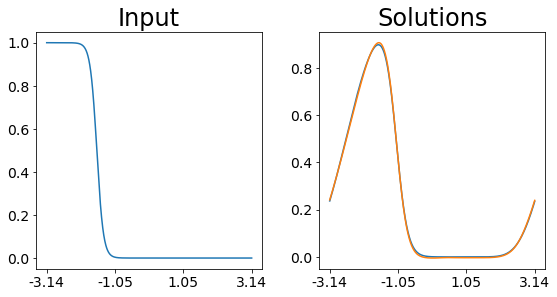

In [82]:
#graph test set results
x = np.pi
ticklist = np.linspace(-x, x, 4)
ticklist = np.round(ticklist, 2)
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
fig = plt.figure(figsize=(12, 12))

for index in range(1):
    data = test_samples[90]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    plt.plot(x[0])
    ax.set_title('Input')

    plt.xticks(np.linspace(0, 1600, 4),labels = ticklist)

    
    ax = fig.add_subplot(3, 3, index*3 + 2)
    plt.plot(y.squeeze())
    plt.plot(out.squeeze().detach().numpy())
    ax.set_title('Solutions')

    plt.xticks(np.linspace(0, 1600, 4),labels = ticklist)




# fig.suptitle('Inputs, ground-truth output and prediction for Burger\'s flow', y=0.98)
plt.tight_layout()

